In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves')

In [2]:
from help_funcs import * 
# from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import xarray as xr
# importlib.reload(xr)
import seaborn as sns
import pandas as pd
import cmocean.cm as cm
import netCDF4 as nc
from pathlib import Path
from natsort import natsorted
import matplotlib.pyplot as plt

In [3]:
sns.set_context("poster")

In [4]:
def rm_each_month_mean(ds):
    xy_mean = ds["thetao"].mean(dim=['latitude', 'longitude'], skipna=True)
    z_mean = xy_mean.mean(dim = "depth")
    return xy_mean - z_mean
def remove_seasonal(ds):
    climatology = ds.groupby("time.month").mean("time")
    anomalies = ds.groupby("time.month") - climatology
    return anomalies.drop("month")

In [5]:
%time
from pathlib import Path
from natsort import natsorted
GLORYS_dir = r"/vortexfs1/home/anthony.meza/GLORYS_data" 
results = [str(result) for result in list(Path(GLORYS_dir).rglob("*.[nN][cC]"))] #get all files
results = natsorted(results) #sort all files 

years = natsorted(list(set([result[41:45] for result in results])))
months = natsorted(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 5.72 µs


In [6]:
#trying to recreate line 90 in California
# y = mx + b 
x0 = -117; y0 = 33
m = ((33 - 31) / (x0 - -125))
b = y0- x0*m 
line = lambda x : m*x + b
xs_C = np.linspace(-125, x0)
ys_C = line(xs_C)

In [7]:
def read_ds(fname): #very little memory footprint, 1 day = 500kib
    with xr.open_dataset(fname) as ds:
        ds_new = ds[["thetao", "so"]]
        ds_new = ds_new.sel(longitude = slice(-128, -115), latitude = slice(25, 35))
        return ds_new

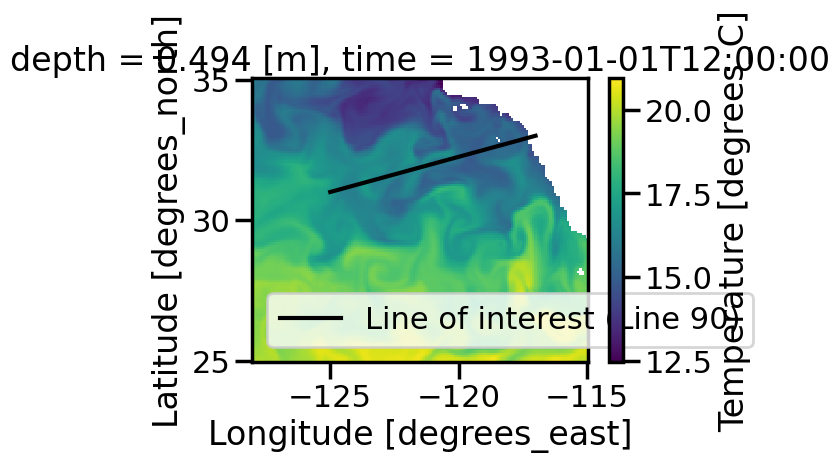

In [8]:
# %%time Must uses axes when plotting with xarray, else there will be a memory leak 
fig, axes = plt.subplots()
with read_ds(results[0]) as ds:
    LONS, LATS = np.meshgrid(ds.longitude, ds.latitude)
    axes.plot(xs_C, ys_C, color = "black", label = "Line of interest (Line 90)"); 
    ds.thetao.isel(time = 0, depth = 0).plot(ax = axes)
    axes.legend()
    fig.tight_layout()

In [9]:
with read_ds(results[0]) as ds:
    i_ind, j_ind = get_latlon_idx(ds, xs_C, ys_C)


In [10]:
#sample along the line 
prev_ind = (np.nan, np.nan)
lons_list = []
lats_list = []
i_ind = []
j_ind = []
tot_dist = []
for (x, y) in zip(xs_C, ys_C): 
    new_ind = where_haversine_min(x, y, LONS, LATS)
    is_unique = new_ind !=prev_ind
    if is_unique:
        i_ind.append(new_ind[0])
        j_ind.append(new_ind[1])
        lons_list.append(LONS[new_ind[0], new_ind[1]])
        lats_list.append(LATS[new_ind[0], new_ind[1]])
        tot_dist.append(haversine_np(lons_list[-1], lats_list[-1], xs_C[-1], ys_C[-1]))
        
    prev_ind = new_ind
#now we have a set of sample pts along a line 

In [11]:
lat_inds = xr.DataArray(i_ind, dims="points")
lon_inds = xr.DataArray(j_ind, dims="points")
def read_ds_line90(fname): #very little memory footprint, 1 day = 500kib
    with xr.open_dataset(fname) as ds:
        ds_new = ds[["thetao", "so"]]
        ds_new = ds_new.sel(longitude = slice(-128, -115), latitude = slice(25, 35))
        ds_new = ds_new.isel(longitude = lon_inds, latitude = lat_inds)
        ds_new = ds_new.mean(dim=['points'], skipna=True) 
        return ds_new

## Getting GLORYS Temperatures for all time on line 90

In [12]:
%%time 
from multiprocessing import Pool
import os 
import multiprocessing
n_cores = 31
from os.path import exists
file_not_exist = not(exists("GLORYS_processed/GLORYS_TandS_SoCal_fulldepth.nc"))

CPU times: user 0 ns, sys: 289 µs, total: 289 µs
Wall time: 799 µs


In [13]:
if file_not_exist:
    print("File does not exist, will download data.")
    print("Requires at least 55 GB of RAM and 40 minutes of time")
    CAL_dataset = []
    for year in years:
        print(year)
        files = np.empty(0, dtype = str)
        for month in months:
            file_path = GLORYS_dir + "/" + year + "/" + month
            file_list = natsorted([str(result) for result in list(Path(GLORYS_dir + "/" + year + "/" + month + "/").rglob("*.[nN][cC]"))])
            files = np.concatenate([files, file_list])
        files = natsorted([str(f) for f in files])
        if __name__ == '__main__':
            with Pool(n_cores) as p:
                datasets = p.map(read_ds_line90, files)
        datasets = [d for d in datasets]
        CAL_dataset = CAL_dataset + datasets #about 50 gigs of data!! 


    ds = xr.concat(CAL_dataset, dim = "time", data_vars = "minimal", coords = "minimal")
    ds = ds.sortby("time")
    ds.to_netcdf("GLORYS_processed/GLORYS_TandS_SoCal_fulldepth.nc")
else:
    print("File found, loading file")
    ds = xr.open_dataset("GLORYS_processed/GLORYS_TandS_SoCal_fulldepth.nc")

File found, loading file


In [14]:
theta_TS = ds.thetao;
salinity_TS = ds.so;

In [15]:
def read_ds_atm(fname): #very little memory footprint, 1 day = 500kib
    with xr.open_dataset(fname) as ds:
        return ds

In [16]:
n_cores = multiprocessing.cpu_count() - 5

ERA5 = []
files = np.empty(0, dtype = str)

for year in range(1992, 2020):
    file_path = ["./ERA5_data/ERA5_" + str(year) +".nc"]
    # file_list = natsorted([str(result) for result in list(Path(file_path).rglob("*.[nN][cC]"))])
    files = np.concatenate([files, file_path])
    
files = natsorted([str(f) for f in files])

if __name__ == '__main__':
    with Pool(n_cores) as p:
        datasets = p.map(read_ds_atm, files)
ERA5 = ERA5 + datasets #about 50 gigs of data!! 

In [45]:
#read in data 
ERA5_ds = xr.concat(ERA5, dim = "time", data_vars = "minimal", coords = "minimal")
ERA5_ds = ERA5_ds.sortby("time")

In [46]:
#resample to daily 
ERA5_ds = 24 * ERA5_ds.resample(time="1W").mean() #mm/hour -> mm/day

In [47]:
tp_anom = remove_seasonal(ERA5_ds.tp).mean(dim = ["latitude", "longitude"]) 
tcwv_anom = remove_seasonal(ERA5_ds.tcwv).mean(dim = ["latitude", "longitude"])

### Get NINO 3.4 Index

In [48]:
df = pd.read_csv("nino34.long.csv", index_col=0)
dates_df = df.astype("datetime64[D]")
for year in range(0, len(df.index)):
    for month in range(1, len(df.columns)+1):
        dates_df.iloc[year, month - 1] = np.datetime64(pd.Timestamp(df.index[year], month, 15), "D")
NINO34_ds = xr.DataArray(
            data=df.values.flatten(),
            dims=["time"],
            coords=dict(time=dates_df.values.flatten()))
NINO34 = NINO34_ds.sel(time = slice("1993", None))

### Get monthly anomalies from each dset 

In [49]:
theta_anom = remove_seasonal(theta_TS).resample(time="1W").mean() #pot. temp anomaly
salinity_anom = remove_seasonal(salinity_TS).resample(time="1W").mean() #salinity anomaly

Text(0.5, 1.0, ' Potential Temperature Anomalies (Seasonal Cycle Removed) \n NINO3.4 Index (overlaid)')

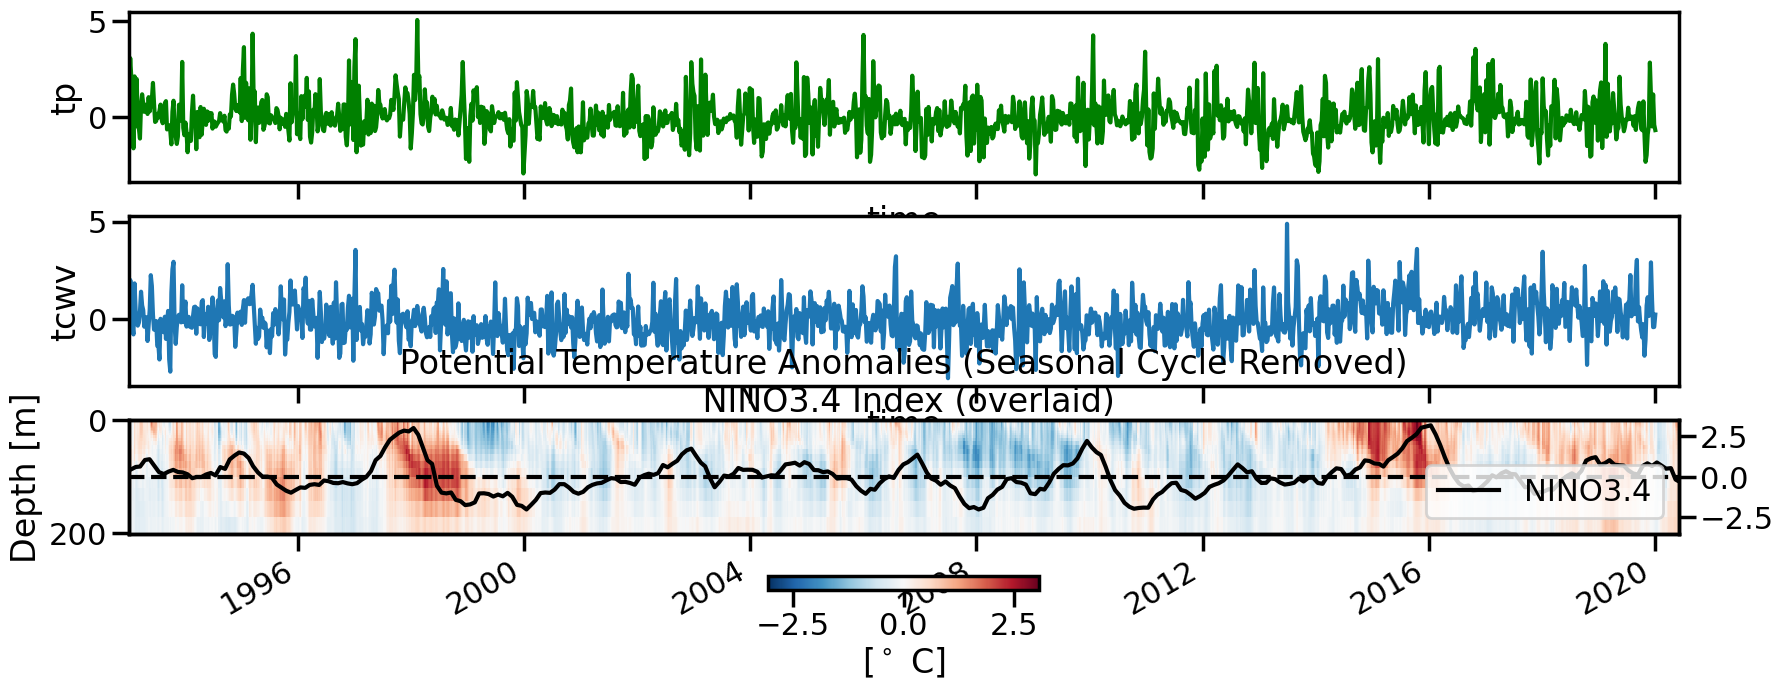

In [57]:
import cmocean.cm as cm 
theta_anom_crop = theta_anom.sel(dict(time = slice(None, "2022"), depth = slice(0, 200))).transpose() #crop
fig, ax = plt.subplots(nrows = 3, figsize = (20, 7.5), sharex = True)


normalize(tp_anom).plot(ax = ax[0], color = "green", label = "TP")
normalize(tcwv_anom).plot(ax = ax[1], label = "TWV")


axes = ax[2]
theta_anom_crop.plot.pcolormesh(ax=axes, 
                cbar_kwargs={'label' : r"[$^\circ$ C]", 
                             'orientation':"horizontal", 
                             "fraction":0.08, 
                             "pad":0.25})
axes.set_xlabel("")
axes.invert_yaxis()
ax2=axes.twinx()
ax2.hlines(0, axes.get_xlim()[0], axes.get_xlim()[1], linestyle = "--", color = "k")
normalize(remove_seasonal(NINO34)).plot(ax = ax2, color = "k", label = "NINO3.4")


# normalize(remove_seasonal(tcwv)).plot(ax = ax2, color = "k", label = "NINO34")



# ax2.set_ylabel("NINO3.4",color="black")
ax2.set_ylim(-3.5, 3.5)
ax2.legend()
axes.set_title(" Potential Temperature Anomalies (Seasonal Cycle Removed) \n NINO3.4 Index (overlaid)")

# fig.tight_layout();

# fig.savefig("TempAnom.png",  dpi = 400)

### Zoom in on 1996 El Nino 

In [70]:
normalize(tp_anom)

<xarray.DataArray 'tp' (time: 1462)>
array([ 2.91383279, -0.64996487, -1.92764794, ...,  1.19147744,
       -0.38685813, -0.66511002])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-05 1992-01-12 ... 2020-01-05

1998-01-04T00:00:00.000000000
1998-02-08T00:00:00.000000000


Text(0.5, 1.0, ' Potential Temperature Anomalies (Seasonal Cycle Removed) \n NINO3.4 Index (overlaid)')

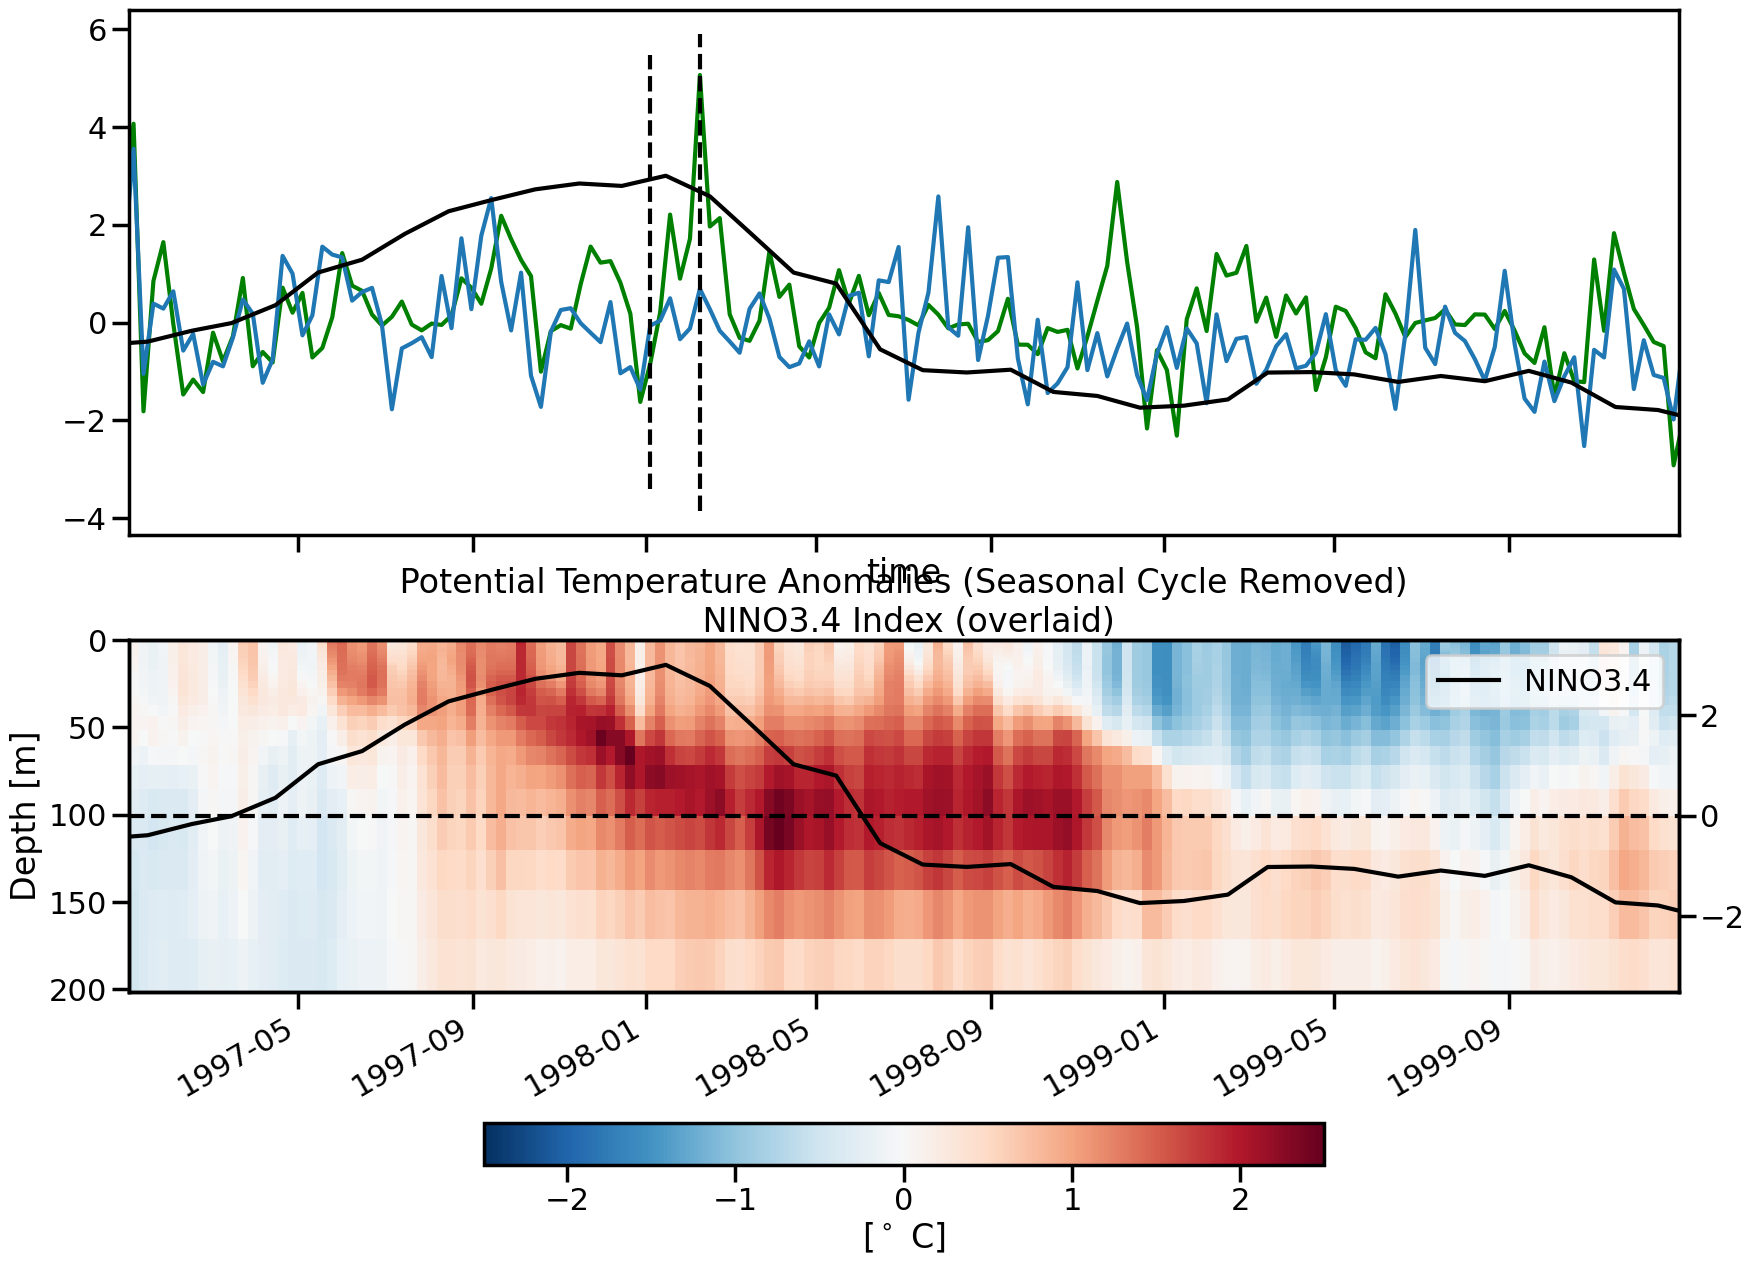

In [93]:
time_slice= slice("1997", "1999")
theta_anom_crop = theta_anom.sel(dict(time = time_slice, depth = slice(0, 200))).transpose() #crop
fig, ax = plt.subplots(nrows = 2, figsize = (20, 15), sharex = True)


normalize(tp_anom).plot(ax = ax[0], color = "green", label = "TP")
normalize(tcwv_anom).plot(ax = ax[0], label = "TWV")
normalize(remove_seasonal(NINO34)).plot(ax = ax[0], color = "k", label = "NINO3.4")

ax[0].vlines(tp_anom.time[4 * 12 * 6 + 25], ax[0].get_ylim()[0], ax[0].get_ylim()[1], linestyle = "--", color = "k")
normalize(remove_seasonal(NINO34)).plot(ax = ax2, color = "k")
print(tp_anom.time[4 * 12 * 6 + 25].values)
ax[0].vlines(tp_anom.time[4 * 12 * 6 + 30], ax[0].get_ylim()[0], ax[0].get_ylim()[1], linestyle = "--", color = "k")
normalize(remove_seasonal(NINO34)).plot(ax = ax2, color = "k")
print(tp_anom.time[4 * 12 * 6 + 30].values)


axes = ax[1]
theta_anom_crop.plot.pcolormesh(ax=axes, 
                cbar_kwargs={'label' : r"[$^\circ$ C]", 
                             'orientation':"horizontal", 
                             "fraction":0.08, 
                             "pad":0.25})
axes.set_xlabel("")
axes.invert_yaxis()
ax2=axes.twinx()
ax2.hlines(0, axes.get_xlim()[0], axes.get_xlim()[1], linestyle = "--", color = "k")
normalize(remove_seasonal(NINO34)).plot(ax = ax2, color = "k", label = "NINO3.4")


# normalize(remove_seasonal(tcwv)).plot(ax = ax2, color = "k", label = "NINO34")



# ax2.set_ylabel("NINO3.4",color="black")
ax2.set_ylim(-3.5, 3.5)
ax2.legend()
axes.set_title(" Potential Temperature Anomalies (Seasonal Cycle Removed) \n NINO3.4 Index (overlaid)")

# fig.tight_layout();

# fig.savefig("TempAnom.png",  dpi = 400)

### Doing an EOF on this time period, see if a wave pattern appears along coastline around the time of 97 Nino event. EOF will be done on the 100m temperature 

In [ ]:
def read_ds(fname): #very little memory footprint, 1 day = 500kib
    with xr.open_dataset(fname) as ds:
        ds_new = ds[["thetao", "so"]].sel(depth = 100, method = "nearest")
        ds_new = ds_new.sel(longitude = slice(-128, -115), latitude = slice(26, 35))
        return ds_new

In [ ]:
%%time 
from multiprocessing import Pool
import os 
import multiprocessing
n_cores = multiprocessing.cpu_count() - 1

NINO_97 = []
for year in ["1997", "1998", "1999", "2000"]:
    print(year)
    files = np.empty(0, dtype = str)
    for month in months:
        file_path = GLORYS_dir + "/" + year + "/" + month
        # file_list = [str(result) for result in list(Path(file_path).rglob("*.[nN][cC]"))]
        file_list = natsorted([str(result) for result in list(Path(GLORYS_dir + "/" + year + "/" + month + "/").rglob("*.[nN][cC]"))])
        files = np.concatenate([files, file_list])
    files = natsorted([str(f) for f in files])
    if __name__ == '__main__':
        with Pool(n_cores) as p:
            datasets = p.map(read_ds, files)
    datasets = [d.drop("depth") for d in datasets]
    NINO_97 = NINO_97 + datasets #about 50 gigs of data!! 
    
